In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
#import librosa
import logging
import os
from scipy.io import wavfile

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [16]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def audio_to_mel_spectrogram(audio_file_path, max_length=4*22500, sr=22500, n_mels=256):
    #audio_file_path = audio_file_path if type(audio_file_path) == str else audio_file_path.decode('ASCII')
    #audio_file_path = str(audio_file_path).replace('\\\\', os.sep)
    #audio_file_path = audio_file_path.replace('F:', '/mnt/f').replace('//', '/')
    
    with open(audio_file_path, 'rb') as fh:
        y, sr = librosa.load(fh, sr=sr)
    
    if len(y) > max_length:
        # If the audio is longer than the maximum length, cut it
        y = y[:max_length]
    elif len(y) < max_length:
        # If the audio is shorter, pad it with zeros
        pad_length = max_length - len(y)
        y = np.pad(y, (0, pad_length), mode='constant')
    
    # Calculate the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram


In [4]:
# Generator function for lazy loading of audio data
def audio_data_generator(audio_files):
    for audio_file in audio_files:
        sample = (audio_to_mel_spectrogram(audio_file) + 80)/80
        yield sample.reshape((1, 128, 176, 1)), sample.reshape((1, 128, 176, 1))

In [5]:
vae_train = pd.read_csv('vae_train.csv')
vae_train_generator = tf.data.Dataset.from_generator(audio_data_generator, args=[vae_train['full_path']], output_signature=(tf.TensorSpec(shape=(1, 128, 176, 1)),tf.TensorSpec(shape=(1, 128, 176, 1))))

In [6]:
vae_val = pd.read_csv('vae_val.csv')
vae_val_generator = tf.data.Dataset.from_generator(audio_data_generator, args=[vae_val['full_path']], output_signature=(tf.TensorSpec(shape=(1, 128, 176, 1)),tf.TensorSpec(shape=(1, 128, 176, 1))))

In [7]:
vae_test = pd.read_csv('vae_test.csv')
vae_test_generator = tf.data.Dataset.from_generator(audio_data_generator, args=[vae_test['full_path']], output_signature=(tf.TensorSpec(shape=(1, 128, 176, 1)),tf.TensorSpec(shape=(1, 128, 176, 1))))

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Normalization, Reshape, Dense, Flatten, Cropping2D
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (128, 176, 1)  # You can adjust the input shape based on your data

# Define the encoder
input_layer = Input(shape=input_shape)
x = input_layer

x = Conv2D(256, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(512)(x)
encoded = x


x = Dense(8*11*16)(x)
x = Reshape((8, 11, 16))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Cropping2D(cropping=((3, 0), (0, 0)))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)

autoencoder.compile(optimizer='adam', loss=mse, metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

# Print the model summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 176, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 176, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 88, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 88, 64)        147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 22, 32)        18464 

In [35]:
autoencoder = tf.keras.saving.load_model('autoencoder_model')
checkpoint_path = 'autoencoder.ckpt'
autoencoder.load_weights(checkpoint_path)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

logging.info('Training the autoencoder...')
# Create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Train the model with class weights and early stopping
history = autoencoder.fit(vae_train_generator, epochs=300, batch_size=128, validation_data=vae_val_generator, callbacks=[early_stopping])

logging.info('Training complete.')

2023-10-21 18:52:47,658 - root - INFO - Training the autoencoder...


Epoch 1/300


c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


   1436/Unknown - 191s 129ms/step - loss: 430.5385 - mean_absolute_error: 0.0916 - mean_absolute_percentage_error: 17289032.0000

KeyboardInterrupt: 

In [ ]:
#train 3,243 batches of 128 (415k)
#val 1,298 batches of 128 (166k)

In [ ]:
autoencoder.save('autoencoder_model')

INFO:tensorflow:Assets written to: autoencoder_model\assets


2023-10-21 18:48:59,635 - tensorflow - INFO - Assets written to: autoencoder_model\assets


c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


1/1 [==============================] - 0s 226ms/step


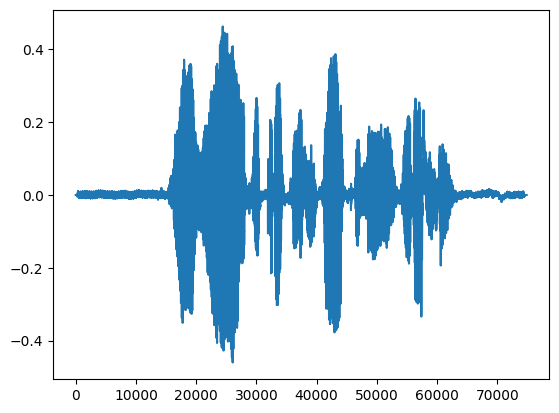

In [100]:
autoencoder = tf.keras.saving.load_model('autoencoder_model')
checkpoint_path = 'autoencoder.ckpt'
autoencoder.load_weights(checkpoint_path)
import soundfile as sf  # Soundfile library for saving the WAV file
def mel_spectrogram_to_audio(mel_spectrogram, max_length=4*22500, sr=22500):
    # Inverse of power_to_db
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    # Inverse of melspectrogram
    y = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr)
    
    return y

# Example usage
spectrogram = audio_to_mel_spectrogram("converted.wav", sr=44100).reshape((1, 128, 176, 1))
spectrogram = (spectrogram+80)/80
out_spectre = autoencoder.predict(spectrogram)
out_spectre = (out_spectre*80)-80
out_spectre = out_spectre.reshape((128, 176))
reconstructed_audio = mel_spectrogram_to_audio(out_spectre, 44100) * 1e2
sf.write("reconstructed_audio.wav", np.ravel(reconstructed_audio), 44100)  # Adjust the sample rate as needed
y, sr = librosa.load('converted.wav', sr=22500, duration=112500)
plt.plot(y)

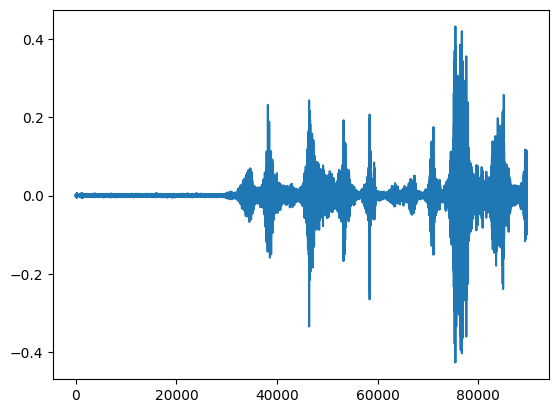

In [101]:
plt.plot(reconstructed_audio)

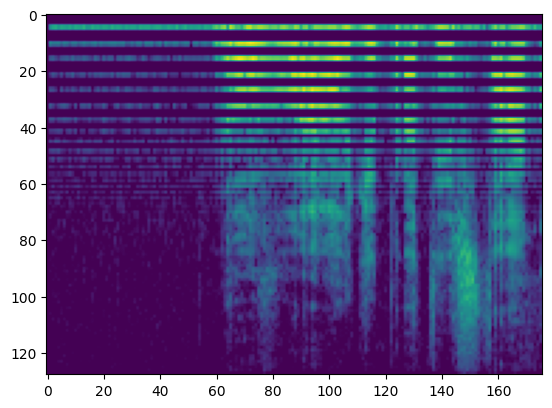

In [102]:
plt.imshow(spectrogram[0])

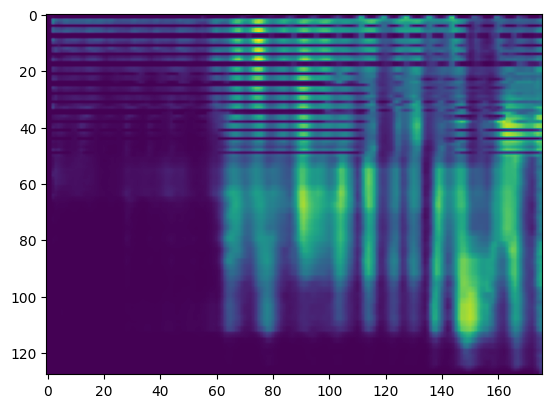

In [103]:
plt.imshow(out_spectre)

1/1 [==============================] - 0s 124ms/step


2023-10-22 20:42:01,571 - tensorflow - WARNING - Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-10-22 20:42:01,573 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.1


2023-10-22 20:42:01,575 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.2


2023-10-22 20:42:01,576 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.3


2023-10-22 20:42:01,577 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.4


2023-10-22 20:42:01,578 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.5


2023-10-22 20:42:01,580 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.6


2023-10-22 20:42:01,582 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.7


2023-10-22 20:42:01,583 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.8


2023-10-22 20:42:01,584 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.9


2023-10-22 20:42:01,586 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.10


2023-10-22 20:42:01,587 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.11


2023-10-22 20:42:01,589 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.12


2023-10-22 20:42:01,590 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.13


2023-10-22 20:42:01,591 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.14


2023-10-22 20:42:01,593 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.15


2023-10-22 20:42:01,594 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.16


2023-10-22 20:42:01,596 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.17


2023-10-22 20:42:01,597 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.18


2023-10-22 20:42:01,599 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.19


2023-10-22 20:42:01,601 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.20


2023-10-22 20:42:01,601 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.21


2023-10-22 20:42:01,603 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.22


2023-10-22 20:42:01,604 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.23


2023-10-22 20:42:01,605 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.24


2023-10-22 20:42:01,607 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.25


2023-10-22 20:42:01,608 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.26


2023-10-22 20:42:01,609 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.27


2023-10-22 20:42:01,610 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.28


2023-10-22 20:42:01,613 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.29


2023-10-22 20:42:01,615 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.30


2023-10-22 20:42:01,616 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.31


2023-10-22 20:42:01,617 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.32


2023-10-22 20:42:01,618 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.33


2023-10-22 20:42:01,620 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.34


2023-10-22 20:42:01,623 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.35


2023-10-22 20:42:01,624 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.36


2023-10-22 20:42:01,626 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.37


2023-10-22 20:42:01,627 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.38


2023-10-22 20:42:01,628 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.39


2023-10-22 20:42:01,631 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.40


2023-10-22 20:42:01,632 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.41


2023-10-22 20:42:01,633 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.42


2023-10-22 20:42:01,634 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.43


2023-10-22 20:42:01,636 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.44


2023-10-22 20:42:01,637 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.45


2023-10-22 20:42:01,639 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.46


2023-10-22 20:42:01,641 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.47


2023-10-22 20:42:01,642 - tensorflow - WARNING - Value in checkpoint could not be found in the restored object: (root).optimizer._variables.48


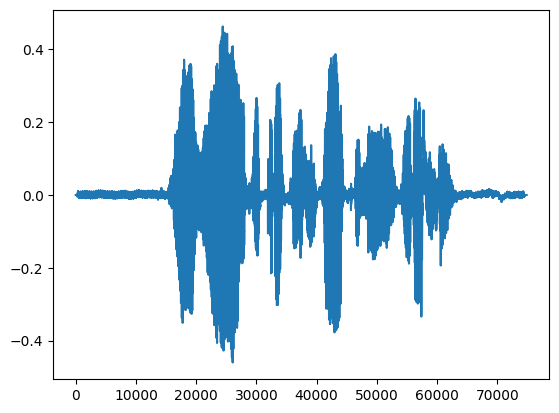

In [104]:
import soundfile as sf  # Soundfile library for saving the WAV file
def mel_spectrogram_to_audio(mel_spectrogram, max_length=4*22500, sr=22500):
    # Inverse of power_to_db
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    # Inverse of melspectrogram
    y = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr)
    
    return y

#sample = next(vae_train_generator.as_numpy_iterator())[0]
flpath = 'F:\\downloads\\en\\clips\\000161e497ddc0966d46f022eb277f5959bdc9bee5b35ef98840bac6bb59565ee5e396c7a14dec1df7e4d1ff86caad7d8fb43e0f39476d394080d02fbe265e72.wav'
spectrogram = audio_to_mel_spectrogram(flpath, sr=44100).reshape((1, 128, 176, 1))
spectrogram = (spectrogram+80)/80
out_spectre = autoencoder.predict(spectrogram)
out_spectre = (out_spectre*80)-80
out_spectre = out_spectre.reshape((128, 176))
reconstructed_audio = mel_spectrogram_to_audio(out_spectre, 44100) * 1e2
#sf.write("reconstructed_audio.wav", np.ravel(reconstructed_audio), 44100)  # Adjust the sample rate as needed
#y, sr = librosa.load('converted.wav', sr=22500, duration=112500)
plt.plot(y)

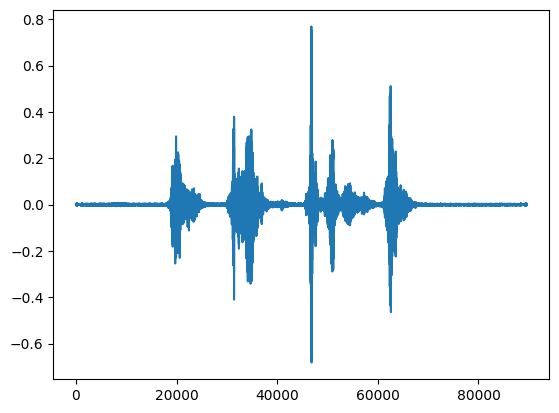

In [105]:
plt.plot(reconstructed_audio)

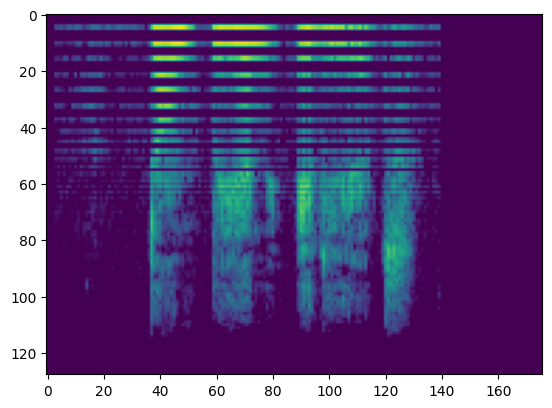

In [106]:
plt.imshow(spectrogram.reshape((128, 176)))

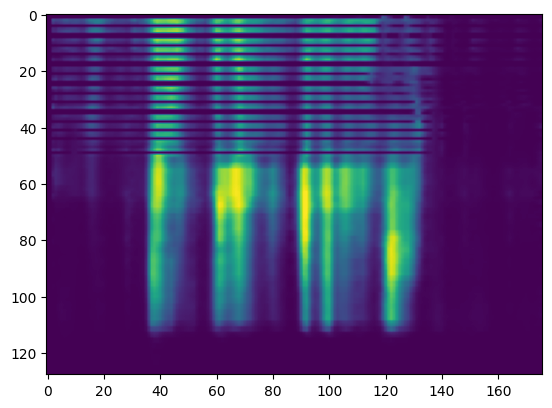

In [107]:
plt.imshow(out_spectre.reshape((128, 176)))

In [76]:
a = spectrogram.reshape((128, 176))
b = out_spectre
(((a+80)/80-(b+80)/80)**2).mean(),\
(((a+80)/80-(b+80)/80)**2).sum()

(0.5815159, 13100.391)